In [1]:
from pathlib import Path

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import yaml
from shapely import Point, Polygon

ox.settings.use_cache = True
ox.settings.log_console = False

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)


def calculate_image_size(
    area_bounds: tuple[float, float, float, float], rx: int, ry: int
) -> tuple[float, float]:
    """
    area_bounds: (minx, miny, maxx, maxy)
    """
    width = (area_bounds[2] - area_bounds[0]) / rx
    height = (area_bounds[3] - area_bounds[1]) / ry
    return width, height


def calculate_top_left_coordinates(area: Polygon, MPx: int, MPy: int, rx: int, ry: int):
    return area.bounds[0] + MPx * rx, area.bounds[3] - MPy * ry


def generate_grid_bottom_left(
    startx: float, starty: float, stepx: float = 500, stepy: float = 500
):
    grid = []
    x = []
    y = []
    # offsetx = 200*stepx
    offsety = 200 * stepy
    for j in range(200):
        for i in range(200):
            p = Polygon(
                [
                    Point(startx + (i * stepx), starty - offsety + (j * stepy)),
                    Point(startx + stepx + (i * stepx), starty - offsety + (j * stepy)),
                    Point(
                        startx + stepx + (i * stepx),
                        starty - offsety + stepy + (j * stepy),
                    ),
                    Point(startx + (i * stepx), starty - offsety + stepy + (j * stepy)),
                ]
            )
            grid.append(p)
            x.append(i + 1)
            y.append(j + 1)
    return gpd.GeoDataFrame(
        {"geometry": grid, "y": x, "x": y}, geometry="geometry", crs=CRS
    )

In [2]:
CRS = 2449  # Japan Plane Rectangular CS VII

rx = 500
ry = 500
STRETCH = True

In [3]:
stretch_suffix = "unstretched"
if STRETCH:
    stretch_suffix = ""
path = f"../figures/{CRS}/{stretch_suffix}"
Path(path).mkdir(parents=True, exist_ok=True)

In [4]:
selected_prefectures = gpd.read_file(
    "../data/geojson/admin4_selected.geojson",
    crs=4326,
)

# Convert to meter-unit projection
selected_prefectures.to_crs(CRS, inplace=True)

coastlines = gpd.read_file("../data/geojson/japan_coastlines.geojson", engine="pyogrio")
coastlines.to_crs(CRS, inplace=True)

clipped = gpd.clip(coastlines, selected_prefectures.unary_union.envelope)

In [5]:
area = selected_prefectures.unary_union.envelope
area = Polygon(
    [(round(i[0] / rx) * rx, round(i[1] / ry) * ry) for i in area.boundary.coords]
)

In [6]:
print(f"bounds: {area.bounds}")
W, H = calculate_image_size(area.bounds, rx, ry)
print(f"width: {W}, height: {H}")

bounds: (-127500.0, -264500.0, 206000.0, 115000.0)
width: 667.0, height: 759.0


In [7]:
# stretch
if STRETCH:
    W = round(W * 1.1)
    H = round(H * 0.9)
print(f"width: {W}, height: {H}")

width: 734, height: 683


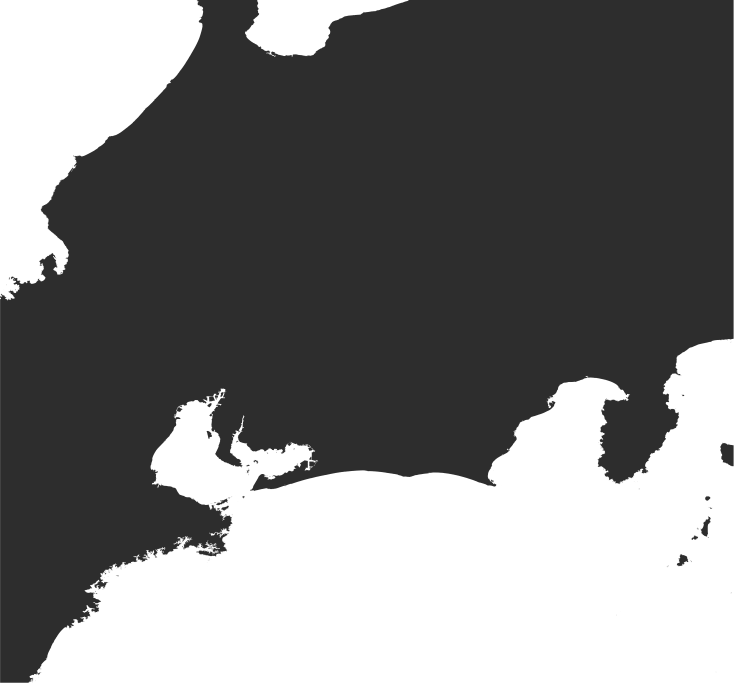

In [8]:
fig = plt.figure(figsize=(W, H), dpi=1)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
gpd.GeoDataFrame(geometry=[area], crs=CRS).plot(
    color="white", aspect=None, ax=ax, zorder=1
)
clipped.plot(color="#2d2d2d", aspect=None, ax=ax, zorder=5)
ax.margins(0)
ax.axis("off")
ax.set_facecolor("white")
fig.patch.set_visible(False)

fig.savefig(
    f"{path}/large.png", facecolor="white", pad_inches=0, metadata=config["metadata"]
)

(306, 147)


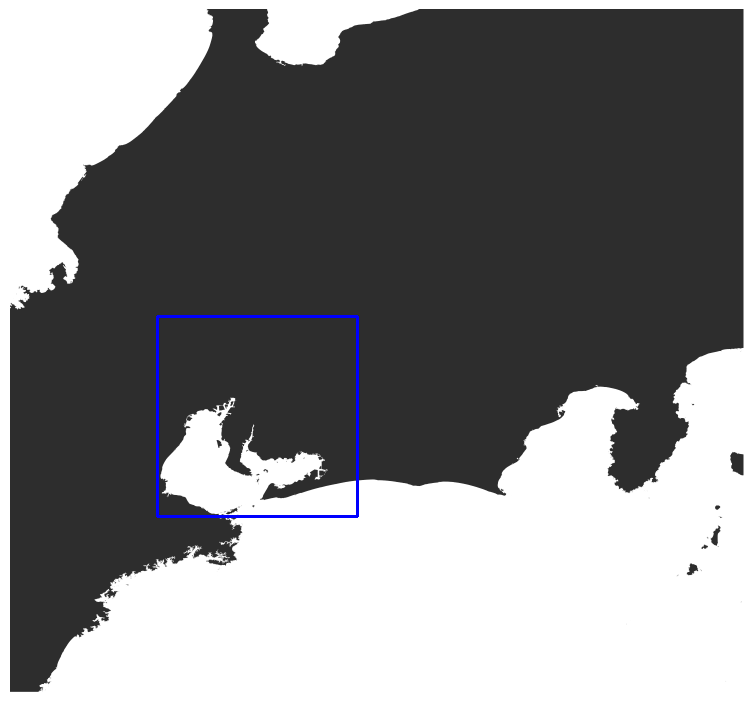

In [9]:
# based on https://stackoverflow.com/a/18075751/4737417
large_image = cv2.imread(f"{path}/large.png")
small_image = cv2.imread("../figures/activity_cut_200.png")
result_a = cv2.matchTemplate(large_image, small_image, cv2.TM_CCOEFF_NORMED)
print(np.unravel_index(result_a.argmax(), result_a.shape))


bg = large_image.copy()
method = cv2.TM_SQDIFF_NORMED
result = cv2.matchTemplate(small_image, bg, method)

# We want the minimum squared difference
mn, _, mnLoc, _ = cv2.minMaxLoc(result)

# Draw the rectangle:
# Extract the coordinates of our best match
MPx, MPy = mnLoc

# Step 2: Get the size of the template. This is the same size as the match.
trows, tcols = small_image.shape[:2]

# Step 3: Draw the rectangle on large_image
cv2.rectangle(bg, (MPx, MPy), (MPx + tcols, MPy + trows), (0, 0, 255), 2)


fig2 = plt.figure(figsize=(W / 100, H / 100), dpi=100)
ax2 = fig2.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax2.imshow(bg)
ax2.axis("off")
ax2.margins(0)
fig2.patch.set_visible(False)
fig2.savefig(
    f"{path}/location.png", facecolor="white", pad_inches=0, metadata=config["metadata"]
)

In [10]:
startx, starty = calculate_top_left_coordinates(area, MPx, MPy, rx, ry)
if STRETCH:
    startx, starty = calculate_top_left_coordinates(area, MPx, MPy, rx / 1.1, ry / 0.9)
print(startx, starty)

-60681.81818181819 -55555.55555555556


In [11]:
if STRETCH:
    g2 = generate_grid_bottom_left(startx, starty, stepx=rx / 1.1, stepy=ry / 0.9)
    g2.to_file(f"../output/grid_bl_{CRS}.geojson")
else:
    g2 = generate_grid_bottom_left(startx, starty, stepx=rx, stepy=ry)
    g2.to_file(f"../output/grid_bl_{CRS}_unstretched.geojson")
print(g2.unary_union.bounds)

(-60681.81818181819, -166666.6666666667, 30227.272727272706, -55555.55555555558)
